# Areas of interest

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import contextily as ctx

In [2]:
geo_antennas = gpd.read_file('../data/affected_btsid/affected_btsid.shp')
geo_antennas.crs = 'EPSG:4674'

zonas_geo = gpd.read_file('../data/zonas/ZONA_C17.shp')
zonas_geo.crs = 'EPSG:4674'

zonas_se = pd.read_csv('../data/auxvars_zone_census.csv.tar.gz')

zonas_geo.GEOCODIGO = zonas_geo.GEOCODIGO.astype(str)
zonas_se.ZONA = zonas_se.ZONA.astype(str)

zonas_geo = zonas_geo.merge(zonas_se, left_on='GEOCODIGO', right_on='ZONA')

geo_antennas = geo_antennas.sjoin(zonas_geo, how='left', predicate='intersects')

In [3]:
warned_towers = pd.read_csv('../data/warned_towers.csv')

warned_towers['date'] = pd.to_datetime(warned_towers['date'])

warned_towers = warned_towers.merge(geo_antennas[['bts_id', 'geometry']], on='bts_id', how='left')
warned_towers = gpd.GeoDataFrame(warned_towers, geometry='geometry', crs='EPSG:4674')

In [4]:
chile_border_adm0 = gpd.read_file('../data/data_meta/borders/chl_admbnda_adm0_bcn_20211008.shp')
chile_border_adm3 = gpd.read_file('../data/data_meta/borders/chl_admbnda_adm3_bcn_20211008.shp')
incendio_gpd = gpd.read_file('../data/ED_AreasAfectadasIncendio_Valparaiso/ED_AreasAfectadasIncendio_Valparaiso.shp')

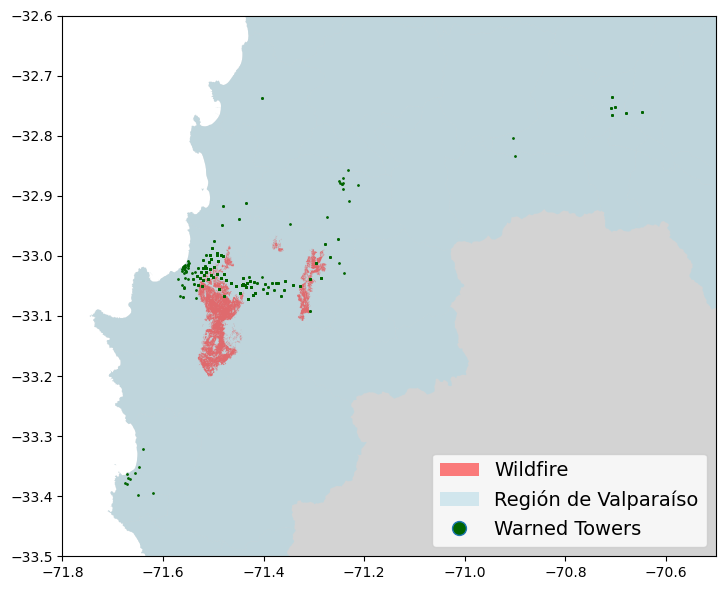

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))  

chile_border_adm0.plot(color='lightgray', ax=ax)
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=ax, alpha=0.5)
incendio_gpd.plot(color='red', alpha=0.5, ax=ax)
warned_towers.plot(color='darkgreen', markersize=1, ax=ax, legend=True)

ax.set_ylim( -33.5, -32.6)
ax.set_xlim(-71.8, -70.5)

rect1 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color='red', alpha=0.5)
rect2 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color='lightblue', alpha=0.5)
rect3 = plt.Line2D([0], [0], marker='o', linewidth=0, markerfacecolor='darkgreen', markersize=10)
handles_to_append = [rect1, rect2, rect3]

# Explicitly specify handles and labels for the legend
handles, labels = [], []
for line in ax.get_lines():
    handles.append(line)
    labels.append(line.get_label())
handles.extend(handles_to_append)

labels_to_append = ['Wildfire', 'Región de Valparaíso', 'Warned Towers']
labels.extend(labels_to_append)

ax.legend(handles, labels, fontsize=14, loc='lower right')

plt.tight_layout()
# plt.savefig('visuals_/map_warned_towers.jpg', dpi=300)

plt.show();

In [6]:
geo_antennas = geo_antennas.to_crs(epsg=3857)
zonas_geo = zonas_geo.to_crs(epsg=3857)
incendio_gpd = incendio_gpd.to_crs(epsg=3857)
warned_towers = warned_towers.to_crs(epsg=3857)
chile_border_adm3 = chile_border_adm3.to_crs(epsg=3857)

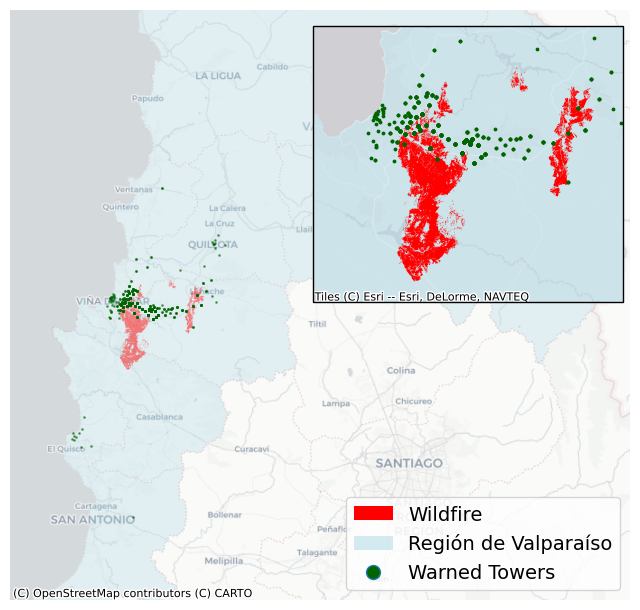

In [7]:
color_map = {'Red': 'red',
             'Yellow': 'yellow',
             'Green': 'green',
             'BMFB': 'black',
             'Outer': 'grey'
             }
geo_antennas['colors'] = geo_antennas['category'].map(color_map)

# Main figure (gdf5, fires, towers)
fig, ax = plt.subplots(figsize=(8, 8))
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=ax, alpha=0.3)
incendio_gpd.plot(ax=ax, facecolor='red', alpha=0.5)
warned_towers.plot(ax=ax, color='darkgreen', markersize=1, alpha=0.5)
ax.set_xlim([-0.8*1e7, -0.779*1e7])
ax.set_ylim([-4*1e6, -3.8*1e6])
ax.set_axis_off()

# Add basemap to the main figure
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create an inset figure (affected_towers)
ax_inset = inset_axes(ax, width="50%", height="50%",
                      loc='upper right')
chile_border_adm3[chile_border_adm3['ADM1_ES'] == 'Región de Valparaíso'].plot(color='lightblue', ax=ax_inset, alpha=0.5)
incendio_gpd.plot(ax=ax_inset, facecolor='red')
warned_towers.plot(ax=ax_inset, color='darkgreen', markersize=3)

# Set limits for the inset plot
ax_inset.set_xlim([-0.7975*1e7, -0.793*1e7])
ax_inset.set_ylim([-3.925*1e6, -3.885*1e6])

ax_inset.set_axis_off()

# Add basemap to the inset figure
ctx.add_basemap(ax_inset, source=ctx.providers.Esri.WorldGrayCanvas)
                # crs=geo_antennas.crs)

# Add a distinctive frame to the inset axis
rect = plt.Rectangle(
    (ax_inset.get_position().x0, ax_inset.get_position().y0),
    ax_inset.get_position().width,
    ax_inset.get_position().height,
    linewidth=1,  # Thickness of the border
    edgecolor='black',  # Color of the border
    facecolor='none',  # No fill inside the frame
    transform=fig.transFigure,  # Make sure the rectangle aligns with the figure coordinates
    linestyle='-',  # Solid line style, can be changed to '--', ':', etc.
    zorder=10       # Ensures the frame appears above other elements
)

fig.patches.append(rect)


rect1 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color='red', alpha=1)
rect2 = patches.Rectangle((0, 0), 1.3, 0.9, linewidth=0, color='lightblue', alpha=0.5)
rect3 = plt.Line2D([0], [0], marker='o', linewidth=0, markerfacecolor='darkgreen', markersize=10)
handles_to_append = [rect1, rect2, rect3]

# Explicitly specify handles and labels for the legend
handles, labels = [], []
for line in ax.get_lines():
    handles.append(line)
    labels.append(line.get_label())
handles.extend(handles_to_append)

labels_to_append = ['Wildfire', 'Región de Valparaíso', 'Warned Towers']
labels.extend(labels_to_append)

ax.legend(handles, labels, fontsize=14, loc='lower right')

fig.savefig('../visuals_created/map_warned_towers_modified.jpeg',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)